### **PyTorch Implementation of DeepLOB for Limit Order Book Prediction**

This notebook demonstrates an implementation of the DeepLOB model architecture in PyTorch. The goal is to predict short-term price movements (up, down, or stationary) based on historical limit order book (LOB) and trade data.

We will:

1. **Load and preprocess data:**  
   - Extract prices, volumes, and order counts for multiple LOB levels.
   - Compute mid-prices, imbalances, and other microstructural features.
   - Incorporate external data (e.g., trades from Binance) to enrich our feature set.
   - Label our data based on future price movements, applying smoothing to reduce noise.

2. **Feature engineering and scaling:**  
   - Create a comprehensive feature matrix, including aggregated volumes, imbalances, spreads, and rolling aggregates of volume.
   - Normalize features to ensure stable training.

3. **Define the DeepLOB architecture in PyTorch:**
   - **Initial convolution layers:** to extract local spatial patterns from the LOB features.
   - **Inception modules:** to capture multi-scale temporal features at each time step.
   - **LSTM layer:** to learn how these features evolve over time, capturing longer-term temporal dependencies.
   - **Final dense layer (softmax output):** to predict the probability of each price movement class.

4. **Training loop:**
   - Train with early stopping to prevent overfitting.
   - Evaluate on a test set and produce metrics like accuracy, precision, recall, and a confusion matrix.

This approach is inspired by the *DeepLOB: Deep Convolutional Neural Networks for Limit Order Books* paper, adapting the architecture into PyTorch and extending it with custom features and data sources.

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.expand_frame_repr', False)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

We use orderbook and trade data of ETH on HyperLiquid

In [36]:
LOB_LEVELS = 10
DATA_PATH = 'C:/Users/trgrd/OneDrive/Trading/Projects/data_download/hyp_data/ETH'
BOOK_FILES = ['ETH_book_20241108.pkl', 'ETH_book_20241109.pkl', 'ETH_book_20241110.pkl']
TRADE_FILES = ['ETH_trade_20241108.pkl', 'ETH_trade_20241109.pkl', 'ETH_trade_20241110.pkl']

# Function to load and concatenate multiple pickle files
def load_and_concat(files, data_path):
    return pd.concat([pd.DataFrame(pd.read_pickle(os.path.join(data_path, f))) for f in files], ignore_index=True)

# Load and concatenate book and trade data
ETH_book = load_and_concat(BOOK_FILES, DATA_PATH)
ETH_trades = load_and_concat(TRADE_FILES, DATA_PATH)

# Define column names for bids and asks
bid_price_cols = [f'BidPrice_{i+1}' for i in range(LOB_LEVELS)]
bid_volume_cols = [f'BidVolume_{i+1}' for i in range(LOB_LEVELS)]
bid_orders_cols = [f'BidOrders_{i+1}' for i in range(LOB_LEVELS)]
ask_price_cols = [f'AskPrice_{i+1}' for i in range(LOB_LEVELS)]
ask_volume_cols = [f'AskVolume_{i+1}' for i in range(LOB_LEVELS)]
ask_orders_cols = [f'AskOrders_{i+1}' for i in range(LOB_LEVELS)]

# Extract bids and asks from the 'levels' column
bids = ETH_book['levels'].apply(lambda x: x[0] if isinstance(x, (list, tuple)) and len(x) > 0 else [])
asks = ETH_book['levels'].apply(lambda x: x[1] if isinstance(x, (list, tuple)) and len(x) > 1 else [])

# Helper function optimized using list comprehensions without appending NaNs
def extract_field(entries, field, levels=LOB_LEVELS):
    return [entry.get(field, np.nan) for entry in entries[:levels]] + [np.nan]*(levels - len(entries[:levels]))

# Extract bid and ask fields
bid_px = bids.apply(lambda x: extract_field(x, 'px')).tolist()
bid_sz = bids.apply(lambda x: extract_field(x, 'sz')).tolist()
bid_n = bids.apply(lambda x: extract_field(x, 'n')).tolist()

ask_px = asks.apply(lambda x: extract_field(x, 'px')).tolist()
ask_sz = asks.apply(lambda x: extract_field(x, 'sz')).tolist()
ask_n = asks.apply(lambda x: extract_field(x, 'n')).tolist()

# Convert lists to NumPy arrays for efficient processing
bid_px_np = np.array(bid_px, dtype=np.float32)
bid_sz_np = np.array(bid_sz, dtype=np.float32)
bid_n_np = np.array(bid_n, dtype=np.float32)

ask_px_np = np.array(ask_px, dtype=np.float32)
ask_sz_np = np.array(ask_sz, dtype=np.float32)
ask_n_np = np.array(ask_n, dtype=np.float32)

# Create a dictionary for all LOB data
lob_data = {
    **{col: bid_px_np[:, i] for i, col in enumerate(bid_price_cols)},
    **{col: bid_sz_np[:, i] for i, col in enumerate(bid_volume_cols)},
    **{col: bid_n_np[:, i] for i, col in enumerate(bid_orders_cols)},
    **{col: ask_px_np[:, i] for i, col in enumerate(ask_price_cols)},
    **{col: ask_sz_np[:, i] for i, col in enumerate(ask_volume_cols)},
    **{col: ask_n_np[:, i] for i, col in enumerate(ask_orders_cols)},
}

# Create the LOB DataFrame
lob_expanded = pd.DataFrame(lob_data)

# Reorder columns to interleave bids and asks efficiently
interleaved_columns = []
for i in range(LOB_LEVELS):
    interleaved_columns.extend([
        f'BidPrice_{i+1}',
        f'BidVolume_{i+1}',
        f'AskPrice_{i+1}',
        f'AskVolume_{i+1}'
    ])

# Create interleaved orders columns
orders_interleaved = []
for i in range(LOB_LEVELS):
    orders_interleaved.extend([
        f'BidOrders_{i+1}',
        f'AskOrders_{i+1}'
    ])

# Combine both interleaved columns
final_column_order = interleaved_columns + orders_interleaved

# Select columns in the specified interleaved order
lob_expanded = lob_expanded[final_column_order]

# Combine with the original ETH_book DataFrame, dropping 'levels' column
eth_book = pd.concat([ETH_book.drop(columns=['levels']), lob_expanded], axis=1)

In [37]:
print(eth_book.iloc[:10, 10:20])

    BidPrice_3  BidVolume_3   AskPrice_3  AskVolume_3  BidPrice_4  BidVolume_4   AskPrice_4  AskVolume_4   BidPrice_5  BidVolume_5
0  2889.600098      32.9823  2890.399902       8.6558      2889.5    25.846399  2890.500000       2.0000  2889.399902    13.648400
1  2889.600098      32.9823  2890.399902       8.6558      2889.5    25.846399  2890.500000       2.0000  2889.399902    13.648400
2  2889.600098      32.9823  2890.399902       8.6558      2889.5    25.846399  2890.500000       2.0000  2889.399902    13.648400
3  2889.600098      32.9823  2890.399902       8.6558      2889.5    25.846399  2890.500000       2.0000  2889.399902    13.648400
4  2889.600098      32.9823  2890.399902       8.6558      2889.5    25.846399  2890.500000       2.0000  2889.399902    13.648400
5  2889.600098      32.9823  2890.399902       8.6558      2889.5    25.846399  2890.500000       2.0000  2889.399902    13.648400
6  2889.600098      32.2033  2890.199951      10.6558      2889.5    17.052200  289

In [38]:
eth_book['MidPrice'] = (eth_book['AskPrice_1'] + eth_book['BidPrice_1']) / 2
eth_book['MidPrice_Next'] = eth_book['MidPrice'].shift(-1)
eth_book['PriceMove'] = 0
eth_book.loc[eth_book['MidPrice_Next'] > eth_book['MidPrice'], 'PriceMove'] = 1
eth_book.loc[eth_book['MidPrice_Next'] < eth_book['MidPrice'], 'PriceMove'] = -1
eth_book = eth_book.dropna(subset=['MidPrice_Next'])

for level in range(1, LOB_LEVELS+1):
    b_vol = eth_book[f'BidVolume_{level}']
    a_vol = eth_book[f'AskVolume_{level}']
    eth_book[f'Imbalance_{level}'] = (b_vol - a_vol) / (b_vol + a_vol)

eth_book['Imbalance_Total'] = (eth_book[[f'BidVolume_{i}' for i in range(1, LOB_LEVELS+1)]].sum(axis=1) -
    eth_book[[f'AskVolume_{i}' for i in range(1, LOB_LEVELS+1)]].sum(axis=1)
) / (
    eth_book[[f'BidVolume_{i}' for i in range(1, LOB_LEVELS+1)]].sum(axis=1) +
    eth_book[[f'AskVolume_{i}' for i in range(1, LOB_LEVELS+1)]].sum(axis=1)
)

for level in range(1, LOB_LEVELS+1):
    eth_book[f'BidOrders_{level}_Change'] = eth_book[f'BidOrders_{level}'].diff()
    eth_book[f'AskOrders_{level}_Change'] = eth_book[f'AskOrders_{level}'].diff()

#### Incorporating Trades and External Data

We add buy/sell trade volumes, number of trades, and also merge in Binance trades data to capture global liquidity signals. Large trades on another exchange can affect short-term price movements here.

In [39]:
# Trades
ETH_trades['sz'] = ETH_trades['sz'].astype(float)
ETH_trades['side'] = ETH_trades['side'].astype(str)
ETH_trades['time'] = pd.to_datetime(ETH_trades['time'], unit='ms')
eth_book.reset_index(inplace=True)
eth_book['time'] = pd.to_datetime(eth_book['time'], unit='ms')

ETH_trades.set_index('time', inplace=True)
eth_book.set_index('time', inplace=True)

eth_book.fillna(0, inplace=True)
eth_book['BidArrivalRate'] = eth_book[[f'BidOrders_{i}_Change' for i in range(1, LOB_LEVELS+1)]].sum(axis=1)
eth_book['AskArrivalRate'] = eth_book[[f'AskOrders_{i}_Change' for i in range(1, LOB_LEVELS+1)]].sum(axis=1)

eth_book['TradeVolume_Buy'] = 0.0
eth_book['TradeVolume_Sell'] = 0.0
eth_book['NumTrades_Buy'] = 0
eth_book['NumTrades_Sell'] = 0
trade_resampled = ETH_trades.groupby('time').agg({'sz':'sum','side':lambda x: x.value_counts().to_dict()})
eth_book = eth_book.merge(trade_resampled, left_index=True, right_index=True, how='left')
eth_book['sz'].fillna(0, inplace=True)
eth_book['side'] = eth_book['side'].apply(lambda x: {} if pd.isnull(x) else x)
eth_book['TradeVolume_Buy'] = eth_book.apply(lambda row: row['sz'] if 'B' in row['side'] else 0, axis=1)
eth_book['TradeVolume_Sell'] = eth_book.apply(lambda row: row['sz'] if 'S' in row['side'] else 0, axis=1)
eth_book['NumTrades_Buy'] = eth_book['side'].apply(lambda x: x.get('B',0))
eth_book['NumTrades_Sell'] = eth_book['side'].apply(lambda x: x.get('S',0))
eth_book.drop(columns=['sz','side'], inplace=True)

In [40]:
# Binance data
binance_trades1 = pd.read_csv('C:/Users/trgrd/OneDrive/Trading/Projects/data_download/Binance_data/ETHUSDT-trades-2024-11-08.csv', header=None)
binance_trades2 = pd.read_csv('C:/Users/trgrd/OneDrive/Trading/Projects/data_download/Binance_data/ETHUSDT-trades-2024-11-09.csv', header=None)
binance_trades3 = pd.read_csv('C:/Users/trgrd/OneDrive/Trading/Projects/data_download/Binance_data/ETHUSDT-trades-2024-11-10.csv', header=None)

binance_trades = pd.concat([binance_trades1, binance_trades2, binance_trades3])
binance_trades = binance_trades.rename(columns={0:'ID', 1:'Price', 2:'Quantity', 3:'Quote_Quantity', 4:'Time', 5:'Is_Buyer_Make', 6:'Ignore'})
binance_trades['Time'] = pd.to_datetime(binance_trades['Time'], unit='ms')
binance_trades.set_index('Time', inplace=True)

threshold = binance_trades['Quantity'].quantile(0.95)
binance_trades['LargeTrade'] = (binance_trades['Quantity'] >= threshold).astype(int)
binance_agg = binance_trades.groupby('Time').agg({'Quantity':'sum','LargeTrade':'sum'})
eth_book = eth_book.merge(binance_agg, how='left', left_index=True, right_index=True)
eth_book['Quantity'].fillna(0, inplace=True)
eth_book['LargeTrade'].fillna(0, inplace=True)
eth_book.rename(columns={'Quantity':'BinanceTotalVolume','LargeTrade':'BinanceLargeTradeCount'}, inplace=True)

eth_book['Lagged_BinanceTotalVolume'] = eth_book['BinanceTotalVolume'].shift(1).fillna(0)
eth_book['Lagged_BinanceLargeTradeCount'] = eth_book['BinanceLargeTradeCount'].shift(1).fillna(0)

window_sizes = [5, 20]
for w in window_sizes:
    eth_book[f'BinanceTotalVolume_rollingSum_{w}'] = (
        eth_book['Lagged_BinanceTotalVolume'].rolling(window=w, min_periods=1).sum()
    )
    eth_book[f'BinanceLargeTradeCount_rollingSum_{w}'] = (
        eth_book['Lagged_BinanceLargeTradeCount'].rolling(window=w, min_periods=1).sum()
    )
    eth_book[f'LargeTrade_flag_{w}'] = (eth_book[f'BinanceLargeTradeCount_rollingSum_{w}'] > 0).astype(int)

#### Additional Derived Features and Label Smoothing

We compute:
- Spread and Relative Spread (measure of liquidity cost)
- Microprice (volume-weighted quote measure)
- VWAP (Volume Weighted Average Price at top level)
- Rolling sums of Binance volume and large trades for capturing local trends

To reduce label noise, we apply smoothing:
$$
m_{\text{prev}} = \frac{1}{S}\sum_{i=0}^{S-1} p_{t-i}, \quad m_{\text{next}} = \frac{1}{S}\sum_{i=1}^{S} p_{t+i}
$$
Then we define a threshold $\alpha$, and label up/down based on:
$$
l_t = \frac{m_{\text{next}}(t) - m_{\text{prev}}(t)}{m_{\text{prev}}(t)}
$$

If $ l_t > \alpha $ label = +1, if $ l_t < -\alpha $ label = -1, else 0. This reduces spurious signals.


In [41]:
eth_book['Spread'] = eth_book['AskPrice_1'] - eth_book['BidPrice_1']
eth_book['RelativeSpread'] = eth_book['Spread'] / eth_book['MidPrice']
eth_book['Microprice'] = (
    eth_book['Imbalance_1']*eth_book['AskPrice_1'] + (1 - eth_book['Imbalance_1'])*eth_book['BidPrice_1']
)
eth_book['VWAP'] = (eth_book['AskPrice_1']*eth_book['AskVolume_1'] + eth_book['BidPrice_1']*eth_book['BidVolume_1']) / (eth_book['AskVolume_1']+eth_book['BidVolume_1'])

S = 10
alpha = 0.00001
m_prev = eth_book['MidPrice'].rolling(window=S, min_periods=1).mean()
m_next = eth_book['MidPrice'].shift(-S).rolling(window=S, min_periods=1).mean()
lt = (m_next - m_prev) / m_prev
eth_book['SmoothedPriceMove'] = 0
eth_book.loc[lt > alpha, 'SmoothedPriceMove'] = 1
eth_book.loc[lt < -alpha, 'SmoothedPriceMove'] = -1

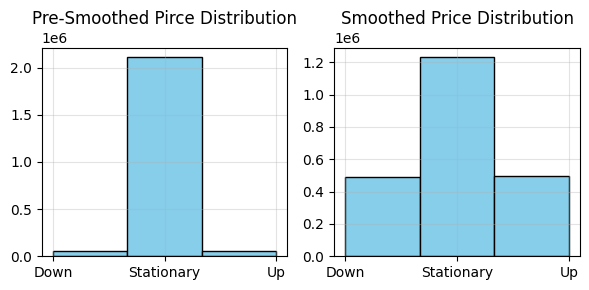

In [42]:
# Difference between price and smoohted price distirbution to handle imblanace and signal-to-noise 
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

ax[0].hist(eth_book['PriceMove'], bins=3, color='skyblue', edgecolor='black')
ax[0].set_title('Pre-Smoothed Pirce Distribution')
ax[0].set_xticks([-1, 0, 1], labels=['Down', 'Stationary', 'Up'])
ax[0].grid(alpha=0.35)

ax[1].hist(eth_book['SmoothedPriceMove'], bins=3, color='skyblue', edgecolor='black')
ax[1].set_title('Smoothed Price Distribution')
ax[1].set_xticks([-1, 0, 1], labels=['Down', 'Stationary', 'Up'])
ax[1].grid(alpha=0.35)

plt.tight_layout()
plt.show()

#### Feature Selection and Data Splitting

We select relevant features and remove the lookahead period. We then split the dataset into training and testing sets. Finally, we scale the features for stable training.

In [44]:
# Target column remains the same
target_col = 'SmoothedPriceMove'

# Include all price, volume, and order features for 10 levels
feature_cols = []
for level in range(1, LOB_LEVELS + 1):
    feature_cols.extend([
        f'BidPrice_{level}', f'AskPrice_{level}',  # Prices
        f'BidVolume_{level}', f'AskVolume_{level}',  # Volumes
        f'BidOrders_{level}', f'AskOrders_{level}'  # Order counts
    ])

# Add derived features
feature_cols.extend([
    'Imbalance_Total', 'BidArrivalRate', 'AskArrivalRate',
    'TradeVolume_Buy', 'TradeVolume_Sell',
    'NumTrades_Buy', 'NumTrades_Sell',
    'BinanceLargeTradeCount', 'Spread', 'RelativeSpread',
    'Microprice', 'VWAP', 'Lagged_BinanceTotalVolume',
    'Lagged_BinanceLargeTradeCount'
])

# Add rolling and flag features from Binance data
for w in window_sizes:
    feature_cols.append(f'BinanceTotalVolume_rollingSum_{w}')
    feature_cols.append(f'BinanceLargeTradeCount_rollingSum_{w}')
    feature_cols.append(f'LargeTrade_flag_{w}')

# Select features for the model
X = eth_book[feature_cols].copy()
y = eth_book[target_col].copy()

In [46]:
# Remove lookahead bias
PREDICTION_HORIZON = 10
X = X.iloc[:-PREDICTION_HORIZON]
y = y.iloc[:-PREDICTION_HORIZON]

train_size = int(0.8 * len(X))
X_train_raw, X_test_raw = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

unique_labels = sorted(y_train.unique())
label_map = {val: idx for idx, val in enumerate(unique_labels)}
inv_label_map = {v: k for k, v in label_map.items()}

y_train_mapped = y_train.map(label_map).values
y_test_mapped = y_test.map(label_map).values

#### Preparing the Data for the Model

We define a `SequenceDataset` that returns windows of data (`WINDOW_SIZE` timesteps) and the label at the end of the window. This aligns with how we train recurrent models (like LSTMs) that process sequences.


In [47]:
WINDOW_SIZE = 100
BATCH_SIZE = 256
EPOCHS = 10
num_classes = len(unique_labels)

class SequenceDataset(Dataset):
    def __init__(self, X, y, window_size=100):
        self.X = X
        self.y = y
        self.window_size = window_size
        
    def __len__(self):
        return len(self.X) - self.window_size
    
    def __getitem__(self, idx):
        X_seq = self.X[idx:idx+self.window_size]  # (window_size, features)
        y_label = self.y[idx+self.window_size-1]  # Label at the end of sequence
        return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_label, dtype=torch.long)

train_dataset = SequenceDataset(X_train_scaled, y_train_mapped, window_size=WINDOW_SIZE)
test_dataset = SequenceDataset(X_test_scaled, y_test_mapped, window_size=WINDOW_SIZE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

#### Defining the DeepLOB Model in PyTorch

- **Convolution layers:** Extract local patterns in LOB features.
- **Inception modules:** Identify patterns at multiple scales simultaneously.
- **LSTM layer:** Capture temporal evolution of these features over time.
- **Final layer:** Output class probabilities (up, down, stationary).

We use `LeakyReLU` activations and `Conv1d` layers. After convolution and inception steps, we run the features through an LSTM, then a final FC (fully connected) layer.

In [48]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, num_filters=32):
        super(InceptionModule, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, num_filters, kernel_size=1, padding=0)
        self.conv3 = nn.Conv1d(in_channels, num_filters, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(in_channels, num_filters, kernel_size=5, padding=2)
        self.pool = nn.MaxPool1d(kernel_size=3, stride=1, padding=1)
        self.convpool = nn.Conv1d(in_channels, num_filters, kernel_size=1, padding=0)
        self.leaky_relu = nn.LeakyReLU(0.01)

    def forward(self, x):
        c1 = self.leaky_relu(self.conv1(x))
        c3 = self.leaky_relu(self.conv3(x))
        c5 = self.leaky_relu(self.conv5(x))
        mp = self.pool(x)
        mp = self.leaky_relu(self.convpool(mp))
        out = torch.cat([c1, c3, c5, mp], dim=1)
        return out

class DeepLOBModel(nn.Module):
    def __init__(self, input_features, num_classes, window_size=100):
        super(DeepLOBModel, self).__init__()
        self.leaky_relu = nn.LeakyReLU(0.01)

        # Initial convolutions to reduce and reorganize features
        self.conv1 = nn.Conv1d(input_features, 16, kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv1d(16, 16, kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv1d(16, 16, kernel_size=10, stride=1, padding=5)  # "same" padding

        # Inception modules to capture multi-scale temporal features
        self.inception1 = InceptionModule(in_channels=16, num_filters=32)
        self.inception2 = InceptionModule(in_channels=128, num_filters=32)  # 128 after first inception

        # LSTM to model temporal dependencies
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, num_classes)
        
    def forward(self, x):
        # x: (batch, window_size, features)
        x = x.transpose(1, 2)  # (batch, features, window_size)
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.conv2(x))
        x = self.leaky_relu(self.conv3(x))
        
        x = self.inception1(x)
        x = self.inception2(x)

        x = x.transpose(1, 2)  # (batch, length, channels)
        _, (h, _) = self.lstm(x)
        h = h[-1]  # final hidden state
        out = self.fc(h)
        return F.log_softmax(out, dim=-1)

#### Training the Model

We use the Adam optimizer and NLLLoss for classification. We implement early stopping to avoid overfitting. Each epoch:
- We train on the training set.
- Validate on the test set.
- If no improvement for a set number of epochs, we stop.

We print training/validation metrics at each epoch.

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepLOBModel(input_features=X_train_scaled.shape[1], num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

best_val_acc = 0.0
patience = 5
no_improve_epochs = 0

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * Xb.size(0)
        pred = out.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += Xb.size(0)

    train_acc = correct / total
    train_loss = train_loss / total

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            out = model(Xb)
            loss = criterion(out, yb)
            val_loss += loss.item() * Xb.size(0)
            pred = out.argmax(dim=1)
            correct_val += (pred == yb).sum().item()
            total_val += Xb.size(0)

    val_acc = correct_val / total_val
    val_loss = val_loss / total_val

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve_epochs = 0
        best_model_state = model.state_dict()
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print("No improvement in validation accuracy for several epochs, stopping early.")
            break
        
model.load_state_dict(best_model_state)

Epoch 1/10, Train Loss: 0.5043, Train Acc: 0.8079, Val Loss: 0.5658, Val Acc: 0.7739
Epoch 2/10, Train Loss: 0.4753, Train Acc: 0.8206, Val Loss: 0.5906, Val Acc: 0.7663
Epoch 3/10, Train Loss: 0.4666, Train Acc: 0.8239, Val Loss: 0.5429, Val Acc: 0.7862
Epoch 4/10, Train Loss: 0.4604, Train Acc: 0.8266, Val Loss: 0.5443, Val Acc: 0.7859
Epoch 5/10, Train Loss: 0.4549, Train Acc: 0.8282, Val Loss: 0.5443, Val Acc: 0.7877
Epoch 6/10, Train Loss: 0.4497, Train Acc: 0.8295, Val Loss: 0.5563, Val Acc: 0.7830
Epoch 7/10, Train Loss: 0.4450, Train Acc: 0.8313, Val Loss: 0.5514, Val Acc: 0.7840
Epoch 8/10, Train Loss: 0.4410, Train Acc: 0.8323, Val Loss: 0.5538, Val Acc: 0.7856
Epoch 9/10, Train Loss: 0.4374, Train Acc: 0.8333, Val Loss: 0.5574, Val Acc: 0.7802
Epoch 10/10, Train Loss: 0.4340, Train Acc: 0.8343, Val Loss: 0.5659, Val Acc: 0.7785
No improvement in validation accuracy for several epochs, stopping early.


<All keys matched successfully>

#### Evaluation

We measure performance on the test set, generate a classification report and a confusion matrix. This helps us understand how well the model predicts different classes (e.g., price going up, staying the same, or going down).

PyTorch DeepLOB Model Classification Report:
              precision    recall  f1-score   support

          -1     0.8009    0.6714    0.7304    111229
           0     0.7482    0.9113    0.8217    218970
           1     0.8510    0.6264    0.7216    112681

    accuracy                         0.7785    442880
   macro avg     0.8000    0.7363    0.7579    442880
weighted avg     0.7876    0.7785    0.7733    442880



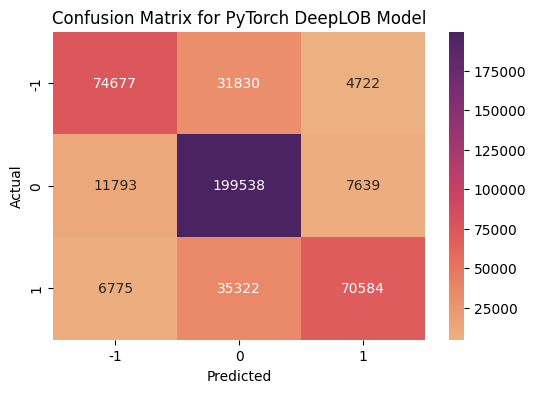

PyTorch DeepLOB Model Accuracy: 0.7785


In [50]:
# Evaluation on test set
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        out = model(Xb)
        preds = out.argmax(dim=1).cpu().numpy()
        targets = yb.cpu().numpy()
        all_preds.append(preds)
        all_targets.append(targets)
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

y_pred_original = np.array([inv_label_map[val] for val in all_preds])
y_true_original = np.array([inv_label_map[val] for val in all_targets])

acc = accuracy_score(y_true_original, y_pred_original)
print("PyTorch DeepLOB Model Classification Report:")
print(classification_report(y_true_original, y_pred_original, digits=4))

conf = confusion_matrix(y_true_original, y_pred_original)
plt.figure(figsize=(6,4))
sns.heatmap(conf, annot=True, fmt='d', cmap='flare', 
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for PyTorch DeepLOB Model')
plt.show()

print(f"PyTorch DeepLOB Model Accuracy: {acc:.4f}")

#### Saving the Model and Scaler
Finally, we save the trained model parameters and the scaler so we can reuse them later for inference or further training.

In [51]:
# Save model and scaler
torch.save(model.state_dict(), 'deeplob_pytorch_model.pt')
joblib.dump(scaler, 'scaler_deeplob.joblib')

['scaler_deeplob.joblib']

### **Conclusion**

- We successfully built a DeepLOB-inspired model in PyTorch.
- We engineered a wide range of features from the LOB and trades data.
- The model uses convolutions and inception modules to handle local and multi-scale patterns, then an LSTM to handle temporal dynamics.
- The final results show decent predictive performance, demonstrating the model's ability to learn from complex, noisy financial data.